In [1]:
import os
import numpy as np
import random
import tensorflow as tf
import pathlib
import pickle
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras import layers, losses, activations, callbacks, optimizers
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
              tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
    

2 Physical GPUs, 2 Logical GPUs


In [2]:
print(tf.__version__)
BATCH_SIZE = 16
EPOCHS = 20
USE_GRAYSCALE = True

2.3.1


In [3]:
data_path = '../data'
images_dir = pathlib.Path(f'{data_path}/images')
class_names = np.array(sorted([item.name for item in images_dir.glob('*') if item.name != ".gitkeep" and item.name != ".ipynb_checkpoints"]))
print(class_names)

with open(os.path.join(data_path, 'diff_specs.pickle'), 'rb') as f:
    spec_diff = pickle.load(f)
    
with open(os.path.join(data_path, 'specs.pickle'), 'rb') as f:
    spec_conv, spec_ae = pickle.load(f)

def load(name, spec):
    out_path = os.path.join(data_path, name)
    if not os.path.exists(out_path):
        raise Exception('Path does not exist')
    return tf.data.experimental.load(out_path, spec)

['bad' 'good']


In [4]:
diff_conv_train_ds = load('diff_conv_train_ds', spec_diff)
diff_conv_val_ds = load('diff_conv_val_ds', spec_diff)
conv_train_ds = load('conv_train_ds', spec_conv)
conv_val_ds = load('conv_val_ds', spec_conv)

if USE_GRAYSCALE:
    diff_conv_train_ds = diff_conv_train_ds.map(lambda x, y: (tf.image.grayscale_to_rgb(x), y))
    diff_conv_val_ds = diff_conv_val_ds.map(lambda x, y: (tf.image.grayscale_to_rgb(x), y))
    
conv_train_ds = conv_train_ds.map(lambda x, y: (x, tf.one_hot(y, 2)))
conv_val_ds = conv_val_ds.map(lambda x, y: (x, tf.one_hot(y, 2)))

In [5]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

diff_conv_train_ds = configure_for_performance(diff_conv_train_ds) 
diff_conv_val_ds = configure_for_performance(diff_conv_val_ds) 

In [6]:
diff_conv_val_ds.element_spec, conv_val_ds.element_spec

((TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)),
 (TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)))

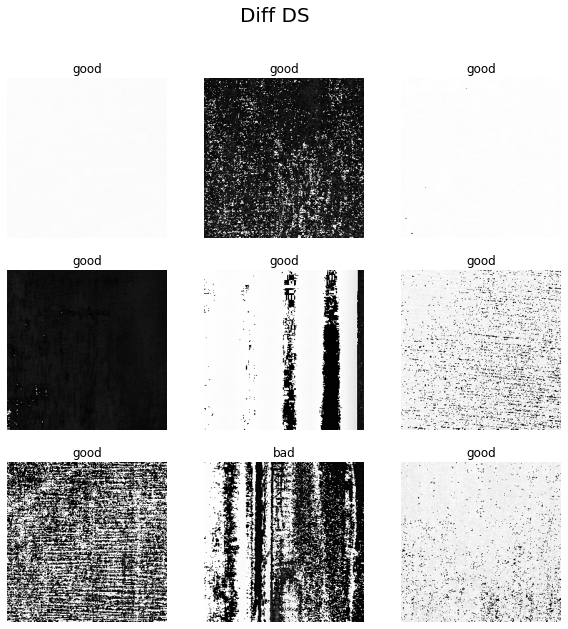

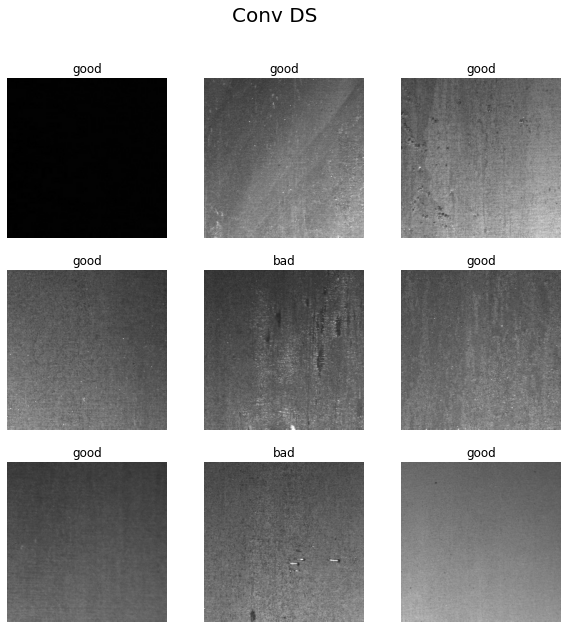

In [8]:
def plot_diff_ds(image_batch, label_batch, grayscale=False):
    fig = plt.figure(figsize=(10, 10))
    fig.suptitle('Diff DS', fontsize=20)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        if grayscale:
            plt.imshow(image_batch[i].numpy().astype("uint8"), cmap='gray', vmin=0, vmax=255)
        else:
            plt.imshow(image_batch[i].numpy().astype("uint8"))
        label = label_batch[i]
        plt.title(class_names[tf.argmax(label, axis=0)])
        plt.axis("off")

image_batch, label_batch = next(iter(diff_conv_val_ds)) 
plot_diff_ds(image_batch, label_batch, USE_GRAYSCALE)

def plot_conv_ds(image_batch, label_batch, grayscale=False):
    fig = plt.figure(figsize=(10, 10))
    fig.suptitle('Conv DS', fontsize=20)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        if grayscale:
            plt.imshow(image_batch[i].numpy().astype("uint8"), cmap='gray', vmin=0, vmax=255)
        else:
            plt.imshow(image_batch[i].numpy().astype("uint8"))
        label = label_batch[i]
        plt.title(class_names[tf.argmax(label, axis=0)])
        plt.axis("off")
        
image_batch, label_batch = next(iter(conv_val_ds)) 
plot_conv_ds(image_batch, label_batch, USE_GRAYSCALE)

## Classifier

In [9]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

class Classifier():
    @staticmethod
    def build(width, height, depth):
        input_shape = (height, width, depth)
        
        inputs = layers.Input(shape=input_shape)
        x = preprocess_input(inputs)
        
        model = EfficientNetB0(
            include_top=False,
            input_tensor=x, 
            weights='imagenet',
            drop_connect_rate=0.3
        )

        model.trainable = False
        
        x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
        x = layers.Dropout(0.3, name="top_dropout")(x)
        outputs = layers.Dense(2, activation='softmax', name="pred")(x)
        
        return tf.keras.Model(inputs, outputs, name="EfficientNetB0")
        

classifier1 = Classifier.build(256, 256, 3) # pretrained models are usually trained on rgb and cannot deal with grayscale. we will alter the data.
classifier1.summary()
classifier2 = Classifier.build(256, 256, 3) # pretrained models are usually trained on rgb and cannot deal with grayscale. we will alter the data.
#classifier1.summary()

Model: "EfficientNetB0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 256, 256, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 257, 257, 3)  0           normalization[0][0]              
_____________________________________________________________________________________

In [10]:
opt = optimizers.Adam(lr=1e-3)
ls=losses.BinaryCrossentropy(from_logits=True)
classifier1.compile(optimizer=opt, loss=ls, metrics=['accuracy'])
classifier2.compile(optimizer=opt, loss=ls, metrics=['accuracy'])

In [11]:
from datetime import datetime

timestamp = datetime.now().isoformat()
def get_callbacks(name=''):
    outpath = os.path.join('..', 'log', 'classifier', name)
    tensorboard_dir = os.path.join(outpath, f'tensorboard')
    if not os.path.exists(tensorboard_dir):
        os.makedirs(tensorboard_dir)
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=tensorboard_dir, histogram_freq=1)

    metrics_dir = os.path.join(outpath, f'metrics')
    if not os.path.exists(metrics_dir):
        os.makedirs(metrics_dir)
    csv_callback = tf.keras.callbacks.CSVLogger(filename=os.path.join(metrics_dir, f'training_log_{timestamp}.csv'))

    checkpoint_dir = os.path.join(outpath, f'checkpoints')
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(verbos=0, 
        filepath=os.path.join(checkpoint_dir, 'weights.{epoch:02d}-{val_accuracy:.2f}-{val_loss:.2f}.hdf5'),
        save_weights_only=True,
        monitor='val_loss',
        mode='auto',
        save_best_only=True,
        save_freq='epoch')

    reduce_lr_plateau_callback = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.5, 
        patience=3, 
        min_lr=0.00001)

    return [tensorboard_callback, csv_callback, checkpoint_callback, reduce_lr_plateau_callback]

In [12]:
history1 = classifier1.fit(diff_conv_train_ds,
                epochs=EPOCHS,
                batch_size=BATCH_SIZE,
                validation_data=diff_conv_val_ds,
                shuffle=True,
                callbacks=get_callbacks('diff'))

Epoch 1/20
  1/355 [..............................] - ETA: 0s - loss: 0.7048 - accuracy: 0.6250WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
355/355 [==============================] - 22s 62ms/step - loss: 0.5975 - accuracy: 0.8317 - val_loss: 0.5854 - val_accuracy: 0.8447
Epoch 2/20
355/355 [==============================] - 19s 55ms/step - loss: 0.5783 - accuracy: 0.8589 - val_loss: 0.5751 - val_accuracy: 0.8730
Epoch 3/20
355/355 [==============================] - 20s 55ms/step - loss: 0.5717 - accuracy: 0.8712 - val_loss: 0.5707 - val_accuracy: 0.8694
Epoch 4/20
355/355 [==============================] - 20s 55ms/step - loss: 0.5712 - accuracy: 0.8664 - val_loss: 0.5684 - val_accuracy: 0.8751
Epoch 5/20
355/355 [==============================] - 20s 55ms

In [13]:
history2 = classifier2.fit(conv_train_ds,
                epochs=EPOCHS,
                batch_size=BATCH_SIZE,
                validation_data=conv_val_ds,
                shuffle=True,
                callbacks=get_callbacks('original'))

Epoch 1/20
178/178 [==============================] - 20s 112ms/step - loss: 0.5860 - accuracy: 0.8400 - val_loss: 0.5693 - val_accuracy: 0.8744
Epoch 2/20
178/178 [==============================] - 18s 103ms/step - loss: 0.5707 - accuracy: 0.8687 - val_loss: 0.5663 - val_accuracy: 0.8779
Epoch 3/20
178/178 [==============================] - 18s 102ms/step - loss: 0.5682 - accuracy: 0.8733 - val_loss: 0.5653 - val_accuracy: 0.8814
Epoch 4/20
178/178 [==============================] - 18s 101ms/step - loss: 0.5672 - accuracy: 0.8737 - val_loss: 0.5638 - val_accuracy: 0.8857
Epoch 5/20
178/178 [==============================] - 18s 101ms/step - loss: 0.5640 - accuracy: 0.8809 - val_loss: 0.5632 - val_accuracy: 0.8857
Epoch 6/20
178/178 [==============================] - 18s 102ms/step - loss: 0.5653 - accuracy: 0.8784 - val_loss: 0.5619 - val_accuracy: 0.8857
Epoch 7/20
178/178 [==============================] - 18s 102ms/step - loss: 0.5637 - accuracy: 0.8827 - val_loss: 0.5611 - val_ac

<Figure size 432x288 with 0 Axes>

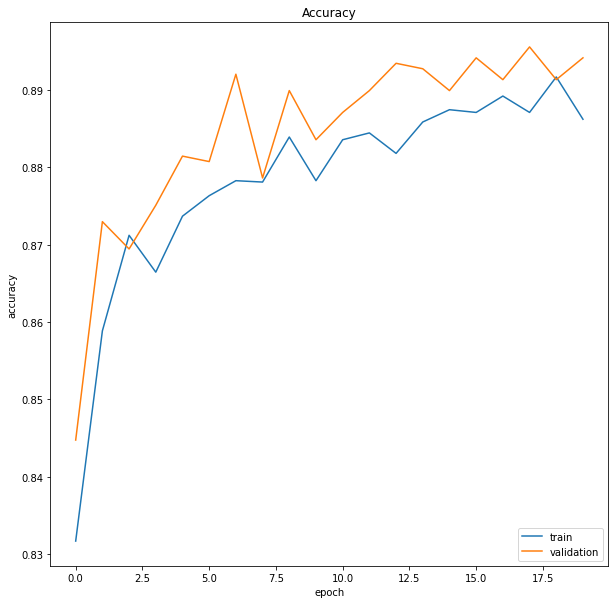

<Figure size 432x288 with 0 Axes>

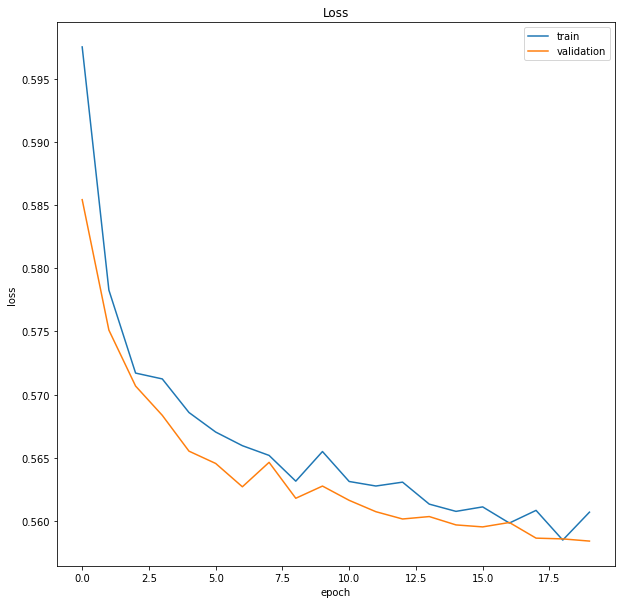

<Figure size 432x288 with 0 Axes>

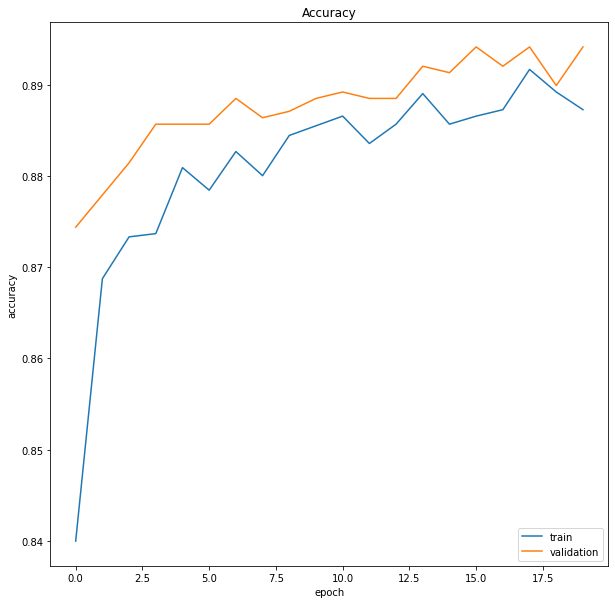

<Figure size 432x288 with 0 Axes>

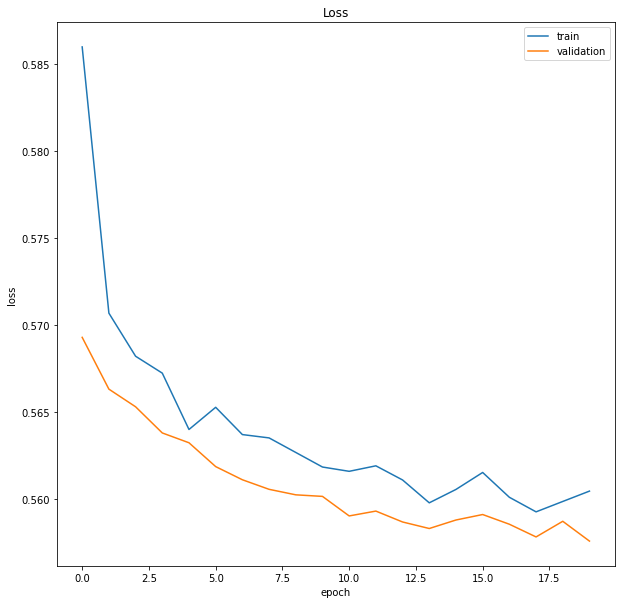

<Figure size 432x288 with 0 Axes>

In [16]:
from sklearn.metrics import confusion_matrix

def plot_accuracy(plot_dir, hist):
    plt.clf()
    plt.figure(figsize=(10,10))
    title = f"Accuracy"
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title(title)
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="lower right")
    plt.show(block=False)
    plt.savefig(os.path.join(plot_dir, f'accuracy_{timestamp}.png'))

def plot_loss(plot_dir, hist):
    plt.clf()
    plt.figure(figsize=(10,10))
    title = f"Loss"
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title(title)
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper right")
    plt.show(block=False)
    plt.savefig(os.path.join(plot_dir, f'loss_{timestamp}.png'))
    
def plot_metrics(history, metrics, name=''):
    outpath = os.path.join('..', 'log')
    plot_dir = os.path.join(outpath, f'plots', name)
    if not os.path.exists(plot_dir):
        os.makedirs(plot_dir)
    if 'accuracy' in metrics:
        plot_accuracy(plot_dir, hist=history)
    if 'loss' in metrics:
        plot_loss(plot_dir, hist=history)
        
plot_metrics(history1, ['accuracy', 'loss'], 'diff')
plot_metrics(history2, ['accuracy', 'loss'], 'original')

In [18]:
def store_model(classifier, name):
    outpath = os.path.join('..', 'log')
    model_save_dir = os.path.join(outpath, f'model', name)
    if not os.path.exists(model_save_dir):
        os.makedirs(model_save_dir)
    classifier.save(os.path.join(model_save_dir, timestamp))
    
store_model(classifier1, 'diff')
store_model(classifier2, 'original')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ../log/model/diff/2020-11-20T08:39:52.460995/assets
INFO:tensorflow:Assets written to: ../log/model/original/2020-11-20T08:39:52.460995/assets


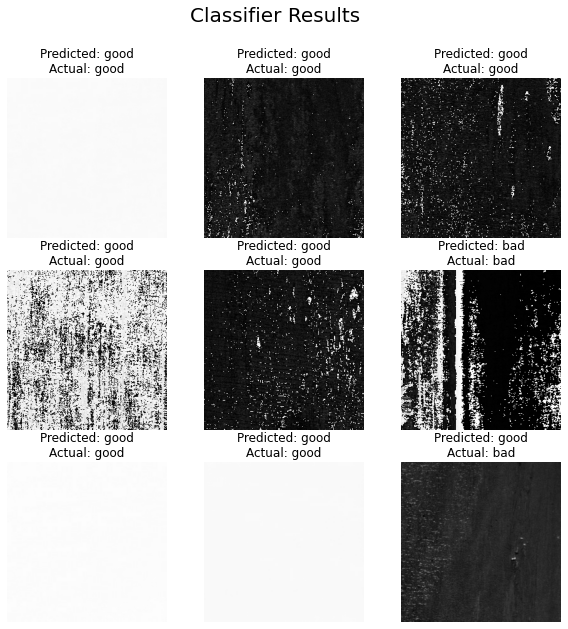

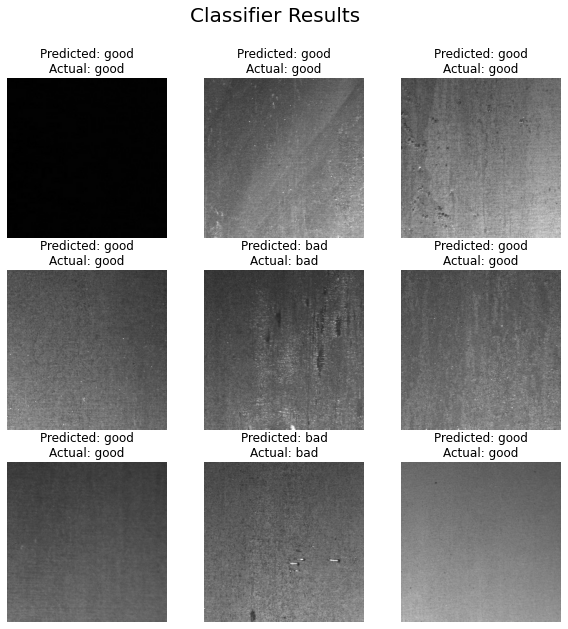

In [20]:
def plot_predictions(dataset, classifier):
    evaluation_example = dataset.take(1)
    image_batch = None
    label_batch = None
    for elem in evaluation_example:
        image_batch = elem[0]
        label_batch = elem[1]
    predicted_label = classifier.predict(evaluation_example)
    
    fig = plt.figure(figsize=(10, 10))
    fig.suptitle('Classifier Results', fontsize=20)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        if USE_GRAYSCALE:
            plt.imshow(image_batch[i].numpy().astype("uint8"), cmap='gray', vmin=0, vmax=255)
        else:
            plt.imshow(image_batch[i].numpy().astype("uint8"))
        label = predicted_label[i]
        label_true = label_batch[i]
        plt.title(f'Predicted: {class_names[tf.argmax(label, axis=0)]}\nActual: {class_names[tf.argmax(label_true, axis=0)]}')
        plt.axis("off")

plot_predictions(diff_conv_val_ds, classifier1)
plot_predictions(conv_val_ds, classifier2)

In [21]:
predictions1 = classifier1.predict(diff_conv_val_ds)
predictions2 = classifier2.predict(conv_val_ds)

def get_true_labels(ds):
    truelabels = list()
    for (_, label) in ds.as_numpy_iterator():
        for l in label:
            truelabels.append(list(l))
    return truelabels

truelabels1 = get_true_labels(diff_conv_val_ds)
truelabels2 = get_true_labels(conv_val_ds)

In [34]:
import seaborn as sns

  
def plot_cm(title, plot_dir, cm):
    plt.clf()
    plt.figure(figsize=(10,10))
    total = np.sum(cm)
    tp = cm[0][0]
    fn = cm[0][1]
    fp = cm[1][0]
    tn = cm[1][1]
    tp_o = np.round((tp / total)*100,3)
    fn_o = np.round((fn / total)*100,3)
    fp_o = np.round((fp / total)*100,3)
    tn_o = np.round((tn / total)*100,3)
    tp_c = np.round(max((tp / (tp + fn)), 0.0)*100,3)
    fn_c = np.round(max((fn / (tp + fn)), 0.0)*100,3)
    fp_c = np.round(max((fp / (fp + tn)), 0.0)*100,3)
    tn_c = np.round(max((tn / (fp + tn)), 0.0)*100,3)
    labels = np.array([[
            f'TP\nCount: {tp}\nOverall: {tp_o}%\nTPR: {tp_c}%', 
            f'FN (Type 2)\nCount: {fn}\nOverall: {fn_o}%\nFNR: {fn_c}%'
        ],[
            f'FP (Type 1)\nCount: {fp}\nOverall: {fp_o}%\nFPR: {fp_c}%', 
            f'TN\nCount: {tn}\nOverall: {tn_o}%\nTNR: {tn_c}%'
        ]])
    sns.heatmap(cm, annot=labels, fmt='')
    plt.title(f'Confusion Matrix - {title}')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.savefig(os.path.join(plot_dir, f'cm_{timestamp}.png'))

outpath = os.path.join('..', 'log')
plot_dir1 = os.path.join(outpath, f'plots', 'diff')
if not os.path.exists(plot_dir1):
        os.makedirs(plot_dir1)
plot_dir2 = os.path.join(outpath, f'plots', 'original')
if not os.path.exists(plot_dir2):
        os.makedirs(plot_dir2)


<Figure size 432x288 with 0 Axes>

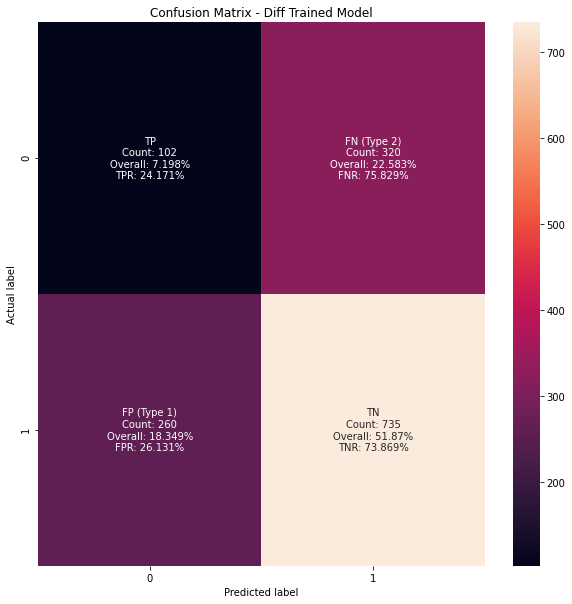

In [35]:
plot_cm('Diff Trained Model', plot_dir1, confusion_matrix(list(map(np.argmax, truelabels1)), list(map(np.argmax, predictions1))))

<Figure size 432x288 with 0 Axes>

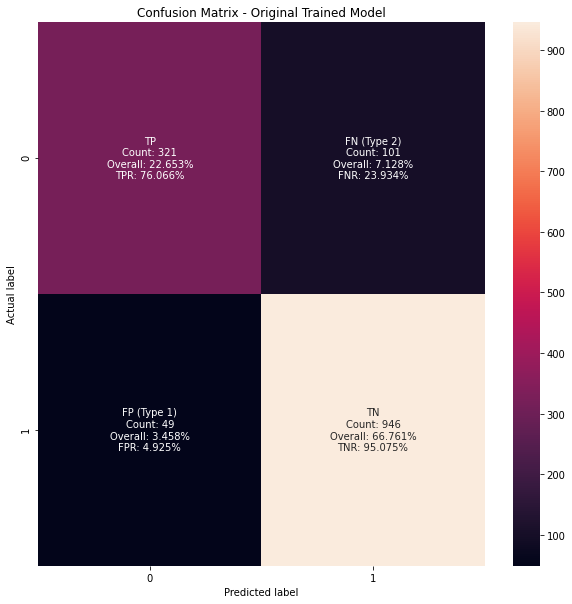

In [36]:
plot_cm('Original Trained Model', plot_dir2, confusion_matrix(list(map(np.argmax, truelabels2)), list(map(np.argmax, predictions2))))